In [21]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [22]:
!find "/content/drive/MyDrive" -type d -name "*cat*"


/content/drive/MyDrive/cat emotion


In [23]:
!ls "/content/drive/MyDrive/cat emotion"
!ls "/content/drive/MyDrive/cat emotion/train"


README.dataset.txt  README.roboflow.txt  train	valid
Angry  Disgusted  Happy  Normal  Sad  Scared  Surprised


In [24]:
DATA_DIR = "/content/drive/MyDrive/cat emotion"
IMG_SIZE = 224
BATCH_SIZE = 16
NUM_WORKERS = 2



In [25]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [26]:
train_transforms = transforms.Compose([

    # 1️⃣ Resize FIRST
    transforms.Resize((224, 224)),

    # 2️⃣ Reflection padding to protect borders
    transforms.Pad(
        padding=16,
        padding_mode="reflect"
    ),

    # 3️⃣ Small safe rotation
    transforms.RandomRotation(
        degrees=7,
        interpolation=transforms.InterpolationMode.BILINEAR
    ),

    # 4️⃣ Center crop back to 224
    transforms.CenterCrop(224),

    # 5️⃣ Horizontal flip
    transforms.RandomHorizontalFlip(p=0.5),

    # 6️⃣ Light color jitter
    transforms.ColorJitter(
        brightness=0.12,
        contrast=0.12,
        saturation=0.12
    ),

    # 7️⃣ Tensor + normalize
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [27]:
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [29]:
from torchvision import datasets, transforms

DATA_DIR = "/content/drive/MyDrive/cat emotion"

TRAIN_DIR = DATA_DIR + "/train"
VAL_DIR   = DATA_DIR + "/valid"

train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

val_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
val_dataset   = datasets.ImageFolder(VAL_DIR, transform=val_transforms)

class_names = train_dataset.classes
num_classes = len(class_names)

print("Classes:", class_names)
print("Number of classes:", num_classes)
print("Train images:", len(train_dataset))
print("Val images:", len(val_dataset))


Classes: ['Angry', 'Disgusted', 'Happy', 'Normal', 'Sad', 'Scared', 'Surprised']
Number of classes: 7
Train images: 502
Val images: 169


In [30]:
print(len(train_dataset), len(val_dataset))

502 169


In [31]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)


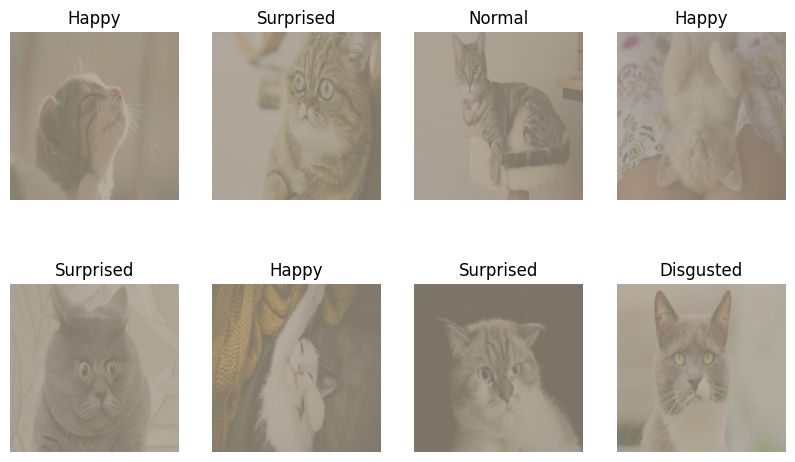

In [32]:
def show_batch(images, labels):
    images = images.permute(0, 2, 3, 1)
    images = images * torch.tensor([0.229, 0.224, 0.225]) + \
             torch.tensor([0.485, 0.456, 0.406])
    images = images.numpy()

    plt.figure(figsize=(10, 6))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(np.clip(images[i], 0, 1))
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()

images, labels = next(iter(train_loader))
show_batch(images, labels)

In [35]:
import torch
import torch.nn as nn
import torchvision.models as models

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [37]:
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 133MB/s]


In [38]:
for param in model.parameters():
    param.requires_grad = False


In [39]:
num_classes = 7  # Angry, Disgusted, Happy, Normal, Sad, Scared, Surprised

in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)


In [40]:
model = model.to(device)


In [41]:
x = torch.randn(1, 3, 224, 224).to(device)
y = model(x)
print("Output shape:", y.shape)


Output shape: torch.Size([1, 7])


In [42]:
from collections import Counter

targets = [label for _, label in train_dataset.samples]
class_count = Counter(targets)

num_classes = len(class_count)

class_weights = torch.tensor(
    [1.0 / class_count[i] for i in range(num_classes)],
    dtype=torch.float
)

class_weights = class_weights / class_weights.sum()
class_weights = class_weights.to(device)

print("Class weights:", class_weights)


Class weights: tensor([0.1432, 0.1643, 0.1643, 0.1355, 0.1591, 0.1269, 0.1066],
       device='cuda:0')


In [43]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [44]:
optimizer = torch.optim.Adam(
    model.fc.parameters(),
    lr=1e-3
)


In [45]:
trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad
)

total_params = sum(p.numel() for p in model.parameters())

print(f"Trainable params: {trainable_params}")
print(f"Total params: {total_params}")

Trainable params: 3591
Total params: 11180103


In [46]:
EPOCHS = 30
PATIENCE = 5          # early stopping patience
best_val_loss = float("inf")
patience_counter = 0

In [47]:
def accuracy_from_logits(logits, labels):
    preds = torch.argmax(logits, dim=1)
    correct = (preds == labels).sum().item()
    return correct / labels.size(0)


In [48]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    print(f"\nEpoch [{epoch+1}/{EPOCHS}]")
    print("-" * 30)

    # =====================
    # 🔥 Training Phase
    # =====================
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += accuracy_from_logits(outputs, labels)

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = running_acc / len(train_loader)

    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)

    # =====================
    # 🧪 Validation Phase
    # =====================
    model.eval()
    running_loss = 0.0
    running_acc = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            running_acc += accuracy_from_logits(outputs, labels)

    epoch_val_loss = running_loss / len(val_loader)
    epoch_val_acc = running_acc / len(val_loader)

    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)

    # =====================
    # 📈 Logging
    # =====================
    print(f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f}")
    print(f"Val   Loss: {epoch_val_loss:.4f} | Val   Acc: {epoch_val_acc:.4f}")

    # =====================
    # ⏹️ Early Stopping
    # =====================
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0

        torch.save(model.state_dict(), "best_cat_emotion_model.pth")
        print("✅ Best model saved")

    else:
        patience_counter += 1
        print(f"⚠️ No improvement ({patience_counter}/{PATIENCE})")

        if patience_counter >= PATIENCE:
            print("⛔ Early stopping triggered")
            break



Epoch [1/30]
------------------------------
Train Loss: 1.9866 | Train Acc: 0.2246
Val   Loss: 1.9951 | Val   Acc: 0.1629
✅ Best model saved

Epoch [2/30]
------------------------------
Train Loss: 1.7017 | Train Acc: 0.3346
Val   Loss: 1.6630 | Val   Acc: 0.3655
✅ Best model saved

Epoch [3/30]
------------------------------
Train Loss: 1.4880 | Train Acc: 0.4876
Val   Loss: 1.5267 | Val   Acc: 0.4451
✅ Best model saved

Epoch [4/30]
------------------------------
Train Loss: 1.3738 | Train Acc: 0.5508
Val   Loss: 1.5107 | Val   Acc: 0.4293
✅ Best model saved

Epoch [5/30]
------------------------------
Train Loss: 1.3113 | Train Acc: 0.5456
Val   Loss: 1.3707 | Val   Acc: 0.4874
✅ Best model saved

Epoch [6/30]
------------------------------
Train Loss: 1.2338 | Train Acc: 0.6100
Val   Loss: 1.3311 | Val   Acc: 0.5202
✅ Best model saved

Epoch [7/30]
------------------------------
Train Loss: 1.1381 | Train Acc: 0.6374
Val   Loss: 1.3463 | Val   Acc: 0.4962
⚠️ No improvement (1/5)



In [50]:
model.load_state_dict(torch.load("best_cat_emotion_model.pth"))
print("Best model loaded successfully")


Best model loaded successfully


In [51]:
import numpy as np
import torch
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns


In [52]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


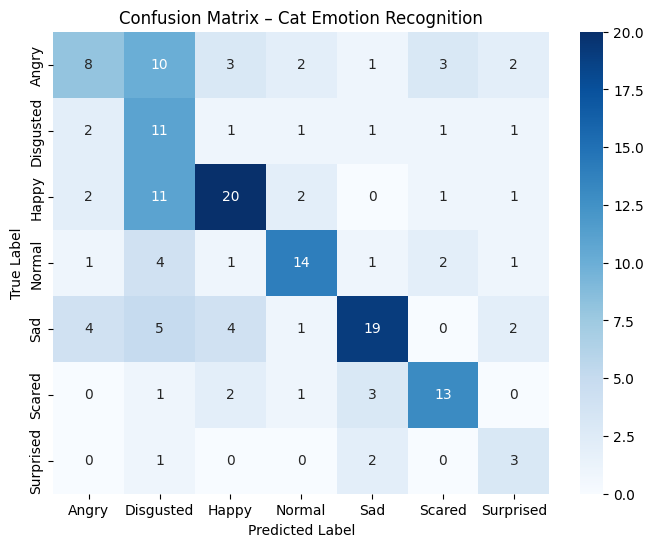

In [53]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Cat Emotion Recognition")
plt.show()


In [54]:
print(
    classification_report(
        all_labels,
        all_preds,
        target_names=class_names,
        digits=4
    )
)


              precision    recall  f1-score   support

       Angry     0.4706    0.2759    0.3478        29
   Disgusted     0.2558    0.6111    0.3607        18
       Happy     0.6452    0.5405    0.5882        37
      Normal     0.6667    0.5833    0.6222        24
         Sad     0.7037    0.5429    0.6129        35
      Scared     0.6500    0.6500    0.6500        20
   Surprised     0.3000    0.5000    0.3750         6

    accuracy                         0.5207       169
   macro avg     0.5274    0.5291    0.5081       169
weighted avg     0.5772    0.5207    0.5324       169



In [55]:
macro_f1 = f1_score(all_labels, all_preds, average="macro")
print("Macro F1-score:", round(macro_f1, 4))


Macro F1-score: 0.5081


In [56]:
# Freeze everything first (safety)
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last ResNet block
for param in model.layer4.parameters():
    param.requires_grad = True

# Also keep classifier trainable
for param in model.fc.parameters():
    param.requires_grad = True


In [57]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())

print(f"Trainable params: {trainable_params}")
print(f"Total params: {total_params}")

Trainable params: 8397319
Total params: 11180103


In [58]:
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4   # 🔴 LOWER than before
)

In [59]:
EPOCHS = 20          # fewer epochs
PATIENCE = 5
best_val_loss = float("inf")
patience_counter = 0


In [60]:
for epoch in range(EPOCHS):
    print(f"\nFine-tune Epoch [{epoch+1}/{EPOCHS}]")
    print("-" * 35)

    # 🔥 Training
    model.train()
    train_loss, train_acc = 0.0, 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += (outputs.argmax(1) == labels).float().mean().item()

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    # 🧪 Validation
    model.eval()
    val_loss, val_acc = 0.0, 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_acc += (outputs.argmax(1) == labels).float().mean().item()

    val_loss /= len(val_loader)
    val_acc /= len(val_loader)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    # ⏹️ Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_finetuned_model.pth")
        print("✅ Best fine-tuned model saved")
    else:
        patience_counter += 1
        print(f"⚠️ No improvement ({patience_counter}/{PATIENCE})")
        if patience_counter >= PATIENCE:
            print("⛔ Early stopping triggered")
            break



Fine-tune Epoch [1/20]
-----------------------------------
Train Loss: 0.8917 | Train Acc: 0.6940
Val   Loss: 1.0173 | Val   Acc: 0.6162
✅ Best fine-tuned model saved

Fine-tune Epoch [2/20]
-----------------------------------
Train Loss: 0.3248 | Train Acc: 0.9062
Val   Loss: 1.0024 | Val   Acc: 0.6105
✅ Best fine-tuned model saved

Fine-tune Epoch [3/20]
-----------------------------------
Train Loss: 0.1857 | Train Acc: 0.9603
Val   Loss: 0.9790 | Val   Acc: 0.6275
✅ Best fine-tuned model saved

Fine-tune Epoch [4/20]
-----------------------------------
Train Loss: 0.0996 | Train Acc: 0.9902
Val   Loss: 1.0105 | Val   Acc: 0.6130
⚠️ No improvement (1/5)

Fine-tune Epoch [5/20]
-----------------------------------
Train Loss: 0.0765 | Train Acc: 0.9909
Val   Loss: 0.9798 | Val   Acc: 0.6686
⚠️ No improvement (2/5)

Fine-tune Epoch [6/20]
-----------------------------------
Train Loss: 0.0718 | Train Acc: 0.9883
Val   Loss: 1.0382 | Val   Acc: 0.6616
⚠️ No improvement (3/5)

Fine-tune

In [61]:
model.load_state_dict(torch.load("best_finetuned_model.pth"))
print("Best fine-tuned model loaded")

Best fine-tuned model loaded


In [62]:
model.load_state_dict(torch.load("best_finetuned_model.pth"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [63]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [64]:
import numpy as np
import torch
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns


In [65]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


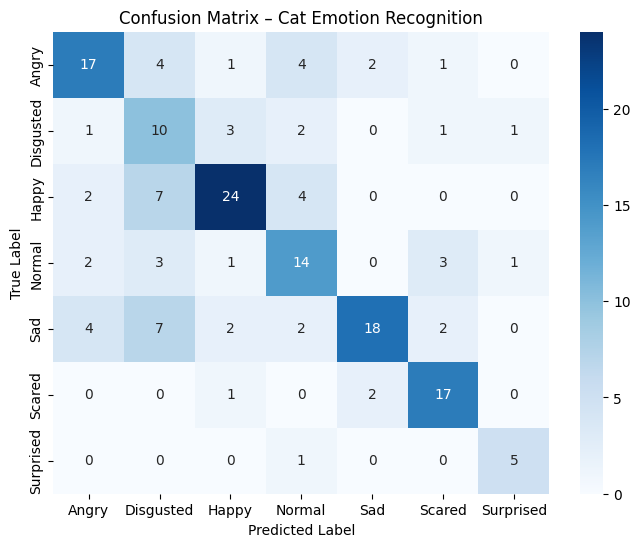

In [66]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Cat Emotion Recognition")
plt.show()


In [67]:
print(
    classification_report(
        all_labels,
        all_preds,
        target_names=class_names,
        digits=4
    )
)

              precision    recall  f1-score   support

       Angry     0.6538    0.5862    0.6182        29
   Disgusted     0.3226    0.5556    0.4082        18
       Happy     0.7500    0.6486    0.6957        37
      Normal     0.5185    0.5833    0.5490        24
         Sad     0.8182    0.5143    0.6316        35
      Scared     0.7083    0.8500    0.7727        20
   Surprised     0.7143    0.8333    0.7692         6

    accuracy                         0.6213       169
   macro avg     0.6408    0.6531    0.6349       169
weighted avg     0.6630    0.6213    0.6294       169



In [68]:
macro_f1 = f1_score(all_labels, all_preds, average="macro")
print("Macro F1-score:", round(macro_f1, 4))


Macro F1-score: 0.6349


Saving 1_a_jpeg.rf.a1e0c6c45927e7a90f23ee271a6b97a6.jpg to 1_a_jpeg.rf.a1e0c6c45927e7a90f23ee271a6b97a6.jpg


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


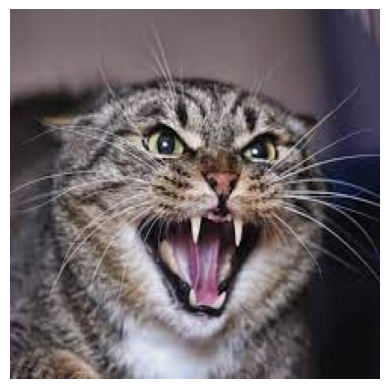

Predicted Emotion: Scared
Confidence: 0.96


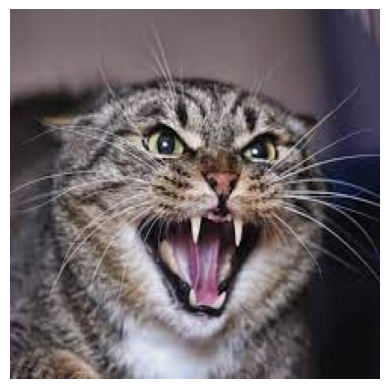

Predicted Emotion: Scared
Confidence: 0.96


In [70]:
from google.colab import files

uploaded = files.upload()   # choose a cat image

class_names = [
    "Angry",
    "Disgusted",
    "Happy",
    "Normal",
    "Sad",
    "Scared",
    "Surprised"
]
from torchvision import transforms
from PIL import Image

infer_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 7)

model.load_state_dict(
    torch.load("/content/best_finetuned_model.pth", map_location=device)
)

model = model.to(device)
model.eval()
import matplotlib.pyplot as plt

# Get uploaded file name
image_path = list(uploaded.keys())[0]

# Load image
image = Image.open(image_path).convert("RGB")

# Show image
plt.imshow(image)
plt.axis("off")
plt.show()

# Preprocess
image_tensor = infer_transform(image).unsqueeze(0).to(device)

# Prediction
with torch.no_grad():
    outputs = model(image_tensor)
    probs = torch.softmax(outputs, dim=1)
    pred_idx = torch.argmax(probs, dim=1).item()

predicted_emotion = class_names[pred_idx]
confidence = probs[0][pred_idx].item()

print(f"Predicted Emotion: {predicted_emotion}")
print(f"Confidence: {confidence:.2f}")
import matplotlib.pyplot as plt

# Get uploaded file name
image_path = list(uploaded.keys())[0]

# Load image
image = Image.open(image_path).convert("RGB")

# Show image
plt.imshow(image)
plt.axis("off")
plt.show()

# Preprocess
image_tensor = infer_transform(image).unsqueeze(0).to(device)

# Prediction
with torch.no_grad():
    outputs = model(image_tensor)
    probs = torch.softmax(outputs, dim=1)
    pred_idx = torch.argmax(probs, dim=1).item()

predicted_emotion = class_names[pred_idx]
confidence = probs[0][pred_idx].item()

print(f"Predicted Emotion: {predicted_emotion}")
print(f"Confidence: {confidence:.2f}")